In [ ]:
!pip install datasets
!pip install nltk
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 22.2 MB/s eta 0:00:00
   ━

In [ ]:
import numpy as np
from sklearn.svm import SVC
from string import punctuation
from tqdm.notebook import tqdm
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tkinter as tk
from tkinter import ttk

# Set seed and constants
SEED = 0
D = 6  # number of features used
SW = stopwords.words("english")
PUNCT = list(punctuation)

# Vectorize function to create feature vectors for each word
def vectorize(w, scaled_position):
    v = np.zeros(D).astype(np.float32)
    v[0] = int(w[0].isupper())
    v[1] = int(w.isupper())
    v[2] = len(w)
    v[3] = int(w.lower() in SW)
    v[4] = int(w in PUNCT)
    v[5] = scaled_position
    return v

# Data preparation function
def createData(data):
    words, features, labels = [], [], []
    for d in tqdm(data):
        tokens, tags = d["tokens"], d["ner_tags"]
        l = len(tokens)
        for i in range(l):
            x = vectorize(w=tokens[i], scaled_position=(i/l))
            y = 1 if tags[i] > 0 else 0
            features.append(x)
            labels.append(y)
        words += tokens
    return np.array(words, dtype="object"), np.array(features, dtype=np.float32), np.array(labels, dtype=np.float32)

# Load dataset
data = load_dataset("conll2003")
data_train, data_val, data_test = data["train"], data["validation"], data["test"]

# Prepare training, validation, and test data
words_train, X_train, y_train = createData(data_train)
words_val, X_val, y_val = createData(data_val)
words_test, X_test, y_test = createData(data_test)

# Standardize the features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train the SVM model
model = SVC(C=1.0, kernel="linear", class_weight="balanced", random_state=SEED, verbose=True)
model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val = model.predict(X_val)
print(classification_report(y_true=y_val, y_pred=y_pred_val))

# Inference function
def infer(sentence):
    tokens = word_tokenize(sentence)
    features = [vectorize(w=tokens[i], scaled_position=(i/len(tokens))) for i in range(len(tokens))]
    features = np.asarray(features, dtype=np.float32)
    scaled_features = scaler.transform(features)
    pred = model.predict(scaled_features)
    result = [(tokens[i], "Named Entity" if pred[i] == 1 else "Not Named Entity") for i in range(len(tokens))]
    return result




  0%|          | 0/14041 [00:00<?, ?it/s]

  0%|          | 0/3250 [00:00<?, ?it/s]

  0%|          | 0/3453 [00:00<?, ?it/s]

[LibSVM]              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     42759
         1.0       0.82      0.97      0.89      8603

    accuracy                           0.96     51362
   macro avg       0.91      0.96      0.93     51362
weighted avg       0.96      0.96      0.96     51362



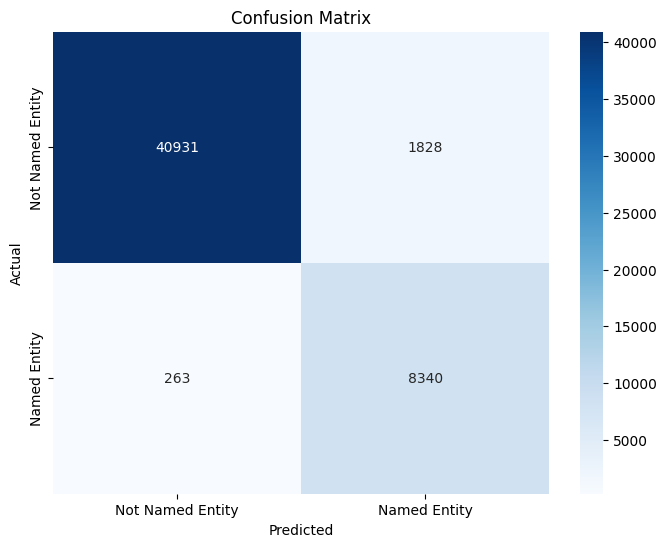

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


conf_matrix = confusion_matrix(y_val, y_pred_val)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Named Entity", "Named Entity"],
            yticklabels=["Not Named Entity", "Named Entity"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import gradio as gr
gr.Interface(
    fn=infer,
    inputs="text",
    outputs="json",
    title="Named Entity Recognition",
    description="Enter a sentence to identify named entities."
).launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a3fba03908f74d6841.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
